In [96]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from pathlib import Path
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter, OrderedDict

model_path = Path('../model/')
data_path = Path('../data/')


%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 15

In [97]:
def count_items(l, reverse = True):
    """Return ordered dictionary of counts of objects in `l`"""
    
    # Create a counter object
    counts = Counter(l)
    
    # Sort by highest count first and place in ordered dictionary
    counts = sorted(counts.items(), key = lambda x: x[1], reverse = reverse)
    counts = OrderedDict(counts)
    
    return counts

In [98]:
with open(model_path/ 'n_deep_embeddings.pkl', 'rb') as fp:
    data = pickle.load(fp)

In [99]:
emb_dims = 50
data_arr = np.array(list(data.values())).reshape(-1, emb_dims)

data_arr = data_arr / np.linalg.norm(data_arr, axis = 1).reshape((-1, 1))
data_arr[0][:10]
np.sum(np.square(data_arr[0]))


data_arr.shape

(12332, 50)

In [100]:
df_data = pd.DataFrame(data_arr, index=data.keys())
df_data = df_data.reset_index().rename(columns={'index':'artist'})
df_data.head()

,artist,0,1,2,3,4,5,6,7,8,...,40,41,42,43,44,45,46,47,48,49
0,Vladimir Horowitz,-0.091848,-0.091038,0.117710,0.105869,-0.021683,0.250209,-0.104084,0.194145,-0.073392,...,-0.068135,-0.155195,-0.088358,-0.138308,-0.068095,0.127026,-0.142657,0.354408,-0.020859,0.159213
1,Seweryn Goszczyński,-0.097241,0.082773,-0.159759,0.073827,-0.083935,0.070037,-0.122974,0.146135,-0.032802,...,-0.121423,0.020126,-0.077257,0.003730,-0.226030,0.018629,0.058169,-0.359647,-0.142619,-0.040815
2,Felix Mendelssohn,0.210015,-0.082061,0.027607,0.138443,0.111154,0.124712,-0.012811,0.199415,0.035305,...,0.161483,0.057608,-0.326180,0.046391,-0.291457,-0.104222,0.077027,0.116595,-0.183208,0.185821
3,Franz Liszt,-0.201702,0.090614,-0.016537,0.320511,0.154164,-0.076035,0.103169,-0.046822,-0.273155,...,-0.090467,-0.028158,-0.260645,-0.051253,0.025570,-0.064119,0.110796,-0.021896,0.032988,-0.083717
4,Charlo,-0.088058,-0.072246,-0.142280,0.066205,0.055326,-0.150830,-0.020738,-0.030411,0.123586,...,-0.112006,0.153655,0.151356,-0.005580,-0.128504,-0.289250,0.011252,0.080597,0.008360,-0.029690


In [101]:
df_data.drop(['artist'], axis=1).to_csv(data_path/'test.tsv', sep='\t', index=False, header=False)

In [102]:
df_path = data_path / Path('df_cleaned__by_artist.csv')
df = pd.read_csv(df_path)

In [104]:
artists_names = df.artists
artists_names = artists_names.str.strip(' ')
drop_artists = []

upper_limit = 200
lower_limit = 30

counts = count_items(artists_names)

for it in counts:
    if counts[it] > upper_limit or counts[it]< lower_limit:
        drop_artists.append(it)
print(f"Remaining artists {len(counts) - len(drop_artists)}")

df = df[~df['artists'].isin(drop_artists)]
print(f"Remaining rows {len(df)}")
artists_names = df.artists
artists_names = artists_names.str.strip(' ')

artists_names = artists_names.reset_index().drop(['index'], axis=1)
artists_names = artists_names.artists
index_artist = dict(((i, artist) for i,artist in  enumerate(artists_names.unique())))
artist_index = dict((val, key) for key,val in index_artist.items() )
len(artist_index), len(index_artist)

Remaining artists 1389
Remaining rows 126029


(12332, 12332)

In [105]:
id_df = pd.DataFrame(index_artist.values(), index=index_artist.keys(), columns=['artist'] )
len(id_df)

12332

In [106]:
id_df.to_csv(data_path/'test_meta.tsv', sep='\t', index=False, header=False)

In [107]:
index = artist_index
rindex = index_artist

# dists = np.dot(data_arr, data_arr[index[name]])

In [108]:
def find_similar(name, weights, index_name, n = 10, least = False, return_dist = False, plot = False):
    """Find n most similar items (or least) to name based on embeddings. Option to also plot the results"""
    

    index = artist_index
    rindex = index_artist
    try:
        # Calculate dot product between book and all others
        dists = np.dot(weights, weights[index[name]])
    except KeyError:
        print(f'{name} Not Found.')
        return
    
    # Sort distance indexes from smallest to largest
    sorted_dists = np.argsort(dists)
    
    # Plot results if specified
    if plot:
        
        # Find furthest and closest items
        furthest = sorted_dists[:(n // 2)]
        closest = sorted_dists[-n-1: len(dists) - 1]
        items = [rindex[c] for c in furthest]
        items.extend(rindex[c] for c in closest)
        
        # Find furthest and closets distances
        distances = [dists[c] for c in furthest]
        distances.extend(dists[c] for c in closest)
        
        colors = ['r' for _ in range(n //2)]
        colors.extend('g' for _ in range(n))
        
        data = pd.DataFrame({'distance': distances}, index = items)
        
        # Horizontal bar chart
        data['distance'].plot.barh(color = colors, figsize = (10, 8),
                                   edgecolor = 'k', linewidth = 2)
        plt.xlabel('Cosine Similarity');
        plt.axvline(x = 0, color = 'k');
        
        # Formatting for italicized title
        name_str = f'{index_name.capitalize()}s Most and Least Similar to'
        for word in name.split():
            # Title uses latex for italize
            name_str += ' $\it{' + word + '}$'
        plt.title(name_str, x = 0.2, size = 28, y = 1.05)
        
        return None
    
    # If specified, find the least similar
    if least:
        # Take the first n from sorted distances
        closest = sorted_dists[:n]
         
        print(f'{index_name.capitalize()}s furthest from {name}.\n')
        
    # Otherwise find the most similar
    else:
        # Take the last n sorted distances
        closest = sorted_dists[-n:]
        
        # Need distances later on
        if return_dist:
            return dists, closest
        
        
        print(f'{index_name.capitalize()}s closest to {name}.\n')
        
    # Need distances later on
    if return_dist:
        return dists, closest
    
    
    # Print formatting
    max_width = max([len(rindex[c]) for c in closest])
    
    # Print the most similar and distances
    for c in reversed(closest):
        print(f'{index_name.capitalize()}: {rindex[c]:{max_width + 2}} Similarity: {dists[c]:.{2}}')

In [111]:
name = 'Drake'
name in artist_index.keys()

True

In [112]:
find_similar(name, data_arr, 'artist', n=10,)

Artists closest to Drake.

Artist: Drake                    Similarity: 1.0
Artist: Jesse & Joy              Similarity: 0.59
Artist: Pantera                  Similarity: 0.5
Artist: Sarah Rice               Similarity: 0.49
Artist: Jack Haley               Similarity: 0.46
Artist: Dickey Betts             Similarity: 0.45
Artist: Eric Leinsdorf           Similarity: 0.44
Artist: Christoph von Dohnányi   Similarity: 0.44
Artist: Termanology              Similarity: 0.43
Artist: Bill Thompson            Similarity: 0.43


In [114]:
from sklearn.manifold import TSNE

In [115]:
def reduce_dim(weights, components = 3, method = 'tsne'):
    """Reduce dimensions of embeddings"""
    if method == 'tsne':
        return TSNE(components, metric = 'cosine').fit_transform(weights)
    elif method == 'umap':
        # Might want to try different parameters for UMAP
        return UMAP(n_components=components, metric = 'cosine', 
                    init = 'random', n_neighbors = 5).fit_transform(weights)

In [117]:
tsne = reduce_dim(data_arr, components = 2, method = 'tsne')
tsne.shape

(12332, 2)

In [119]:
from IPython.core.interactiveshell import InteractiveShell

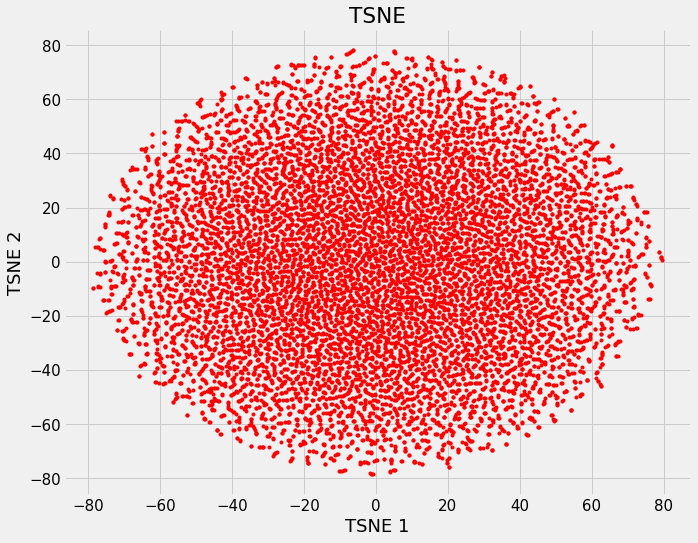

In [120]:
InteractiveShell.ast_node_interactivity = 'last'

plt.figure(figsize = (10, 8))
plt.plot(tsne[:, 0], tsne[:, 1], 'r.')
plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title('TSNE');